In [1]:
import leafmap
from samgeo import SamGeo2, raster_to_vector, regularize
import os
import rasterio as r
from geo import *
from samgeo.text_sam import LangSAM
import geopandas as gpd
import matplotlib.pyplot as plt
from langrs import LangRS

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'


In [2]:
training_pts_fp = f'greenroof_pts.geojson'


data_dir= '../../datasets/chicago_25cm'
images= [f'{data_dir}/{x}' for x in os.listdir(data_dir) if x.split('.')[-1] == 'tif']

# Get Training Points
training_pts = gpd.read_file(training_pts_fp)
training_pts = training_pts[training_pts['class'] == 1]
point_crs = str(training_pts.crs)
point_labels = training_pts['class'].to_list()
point_coords = training_pts.geometry.apply(lambda pt: [pt.x,pt.y]).to_list()

image = images[0]
image = f'{data_dir}/447000e4638000n_rgb_test.tif'
bbox = rio_get_bbox(image)
bbox_4326 = bbox.to_crs(4326)
center = bbox_4326.centroid.iloc[0]



In [21]:
prompt = 'tree'
output_path = 'outputs'
# output_path = "masks.tif"
seg_params = {"box_threshold": 0.25, "text_threshold": 0.25}

## Initialize LangSAM

In [4]:
sam = LangSAM(model_type="sam2-hiera-large")
text_prompt = "plant"
sam.predict(image, text_prompt, **seg_params)

final text_encoder_type: bert-base-uncased
No objects found in the image.


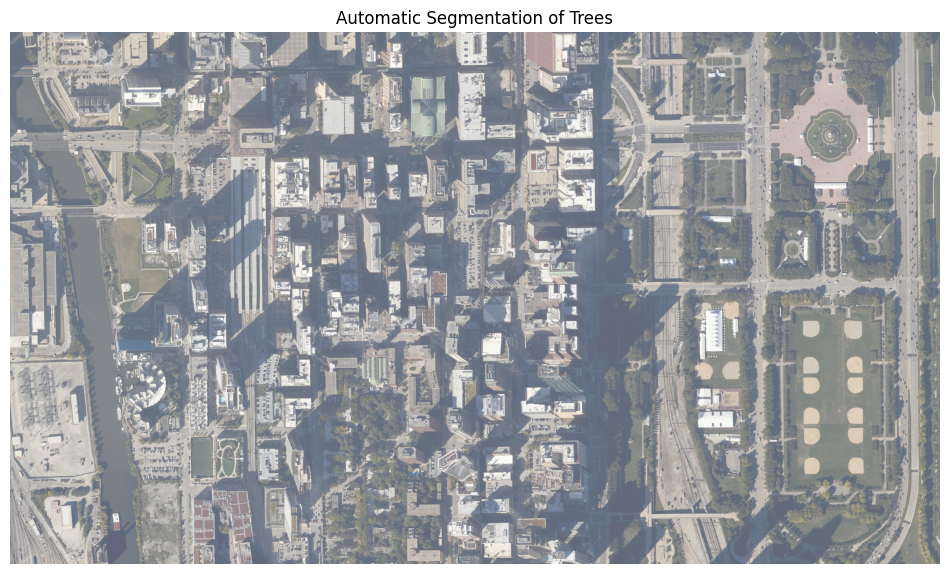

In [5]:
sam.show_anns(
    cmap="Greens",
    box_color="red",
    title="Automatic Segmentation of Trees",
    blend=True,
)

In [20]:
del sam
import torch
torch.cuda.empty_cache()

NameError: name 'sam' is not defined

## LangRS

In [22]:
model = LangRS(image=image, prompt=prompt, output_path=output_path)

final text_encoder_type: bert-base-uncased


In [23]:
bounding_boxes = model.generate_boxes(window_size=500, overlap=200, **seg_params)

In [24]:
input_image = model.pil_image
bboxes_filtered = model.outlier_rejection()
bboxes_filtered.keys()
bboxes_zscore = bboxes_filtered['zscore']

In [25]:
from langrs.common import apply_nms

bboxes_zscore_filtered = apply_nms(bboxes_zscore, iou_threshold=0.6)
masks = model.generate_masks(boxes=bboxes_zscore_filtered[0:3])

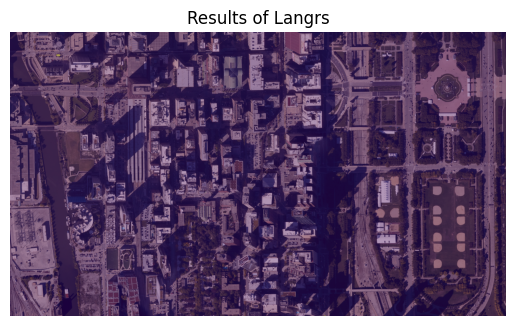

In [26]:
fig, ax = plt.subplots()
ax.imshow(input_image)
ax.imshow(masks, cmap="viridis", alpha=0.4)
ax.axis('off')  # Turn off the axes

plt.title("Results of Langrs")
plt.show()
plt.close()

In [27]:
# # m = sam2.show_map()

# m = leafmap.Map(center=[center.x, center.y], zoom=16, height="800px")
# m.add_basemap("Satellite")
# m.layers[-1].visible = False
# m.add_raster(image, layer_name="Image")
# m.add_raster('masks.tif', cmap='viridis', nodata=0)
# m
